In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle
import csv
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy.stats import spearmanr
from IPython.display import display, Image

In [346]:
#Function to calculate Z score
def calculateZScore(row):
    card_number = row['Card Number']
    mean_amount = cardStats[card_number]['Mean Amount']
    std_amount = cardStats[card_number]['Std Amount']
    zScore = (row['Amount'] - mean_amount) / std_amount
    return zScore

In [347]:
#Read from file, change columns
file_path1 = r"C:\Users\youss\Desktop\FraudDetection\fraudTrain.csv"
file_path2 = r"C:\Users\youss\Desktop\FraudDetection\fraudTest.csv"

df = pd.read_csv(file_path1)
#df2 = pd.read_csv(file_path2)
#df = pd.concat([df1, df2], ignore_index=True)

df.set_index('trans_num', inplace = True)
df = df.drop('ID', axis = 1)
df = df.drop('firstName', axis = 1)
df = df.drop('lastName', axis = 1)

In [348]:
#Change time string to object
df["Time"] = pd.to_datetime(df["Time"], errors='coerce')
df.dropna(inplace=True)

In [349]:
#Split time to Day of week, hour, and month
df['Hour of Day'] = df['Time'].dt.hour
df['Day of Week'] = df['Time'].dt.dayofweek
df['Month'] = df['Time'].dt.month

#Turn category into labels
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['category'])
for x in range(len(list(label_encoder.classes_))):
    print(x, list(label_encoder.classes_)[x])
df = df.drop("category", axis = 1)
df = df.drop('merchant', axis = 1) #Remove merchant, too many different labels

0 entertainment
1 food_dining
2 gas_transport
3 grocery_net
4 grocery_pos
5 health_fitness
6 home
7 kids_pets
8 misc_net
9 misc_pos
10 personal_care
11 shopping_net
12 shopping_pos
13 travel


In [350]:
#Group data by card num
grouped_by_card = df.groupby('Card Number')
cardStats = {}

#calculate standard deviation for each card
for card, data in grouped_by_card:
    mean = data['Amount'].mean()
    std = data['Amount'].std()
    cardStats[card] = {'Mean Amount': mean, 'Std Amount': std}

#save data into a dictionary to potentially be used
cardStatsDf = pd.DataFrame.from_dict(cardStats, orient='index')
cardStatsDf.to_csv('CardStats.csv')

In [351]:
#Apply Z Score Function
df['Z Score'] = df.apply(calculateZScore, axis = 1)

In [352]:
#sort data by time
df_sorted = df.sort_values(by=['Card Number', 'Time'])

#.diff() calculates the difference between consecutive entries
df['Time Difference'] = df_sorted.groupby('Card Number')['Time'].diff().dt.total_seconds()
median = df['Time Difference'].median()
df['Time Difference'] = df['Time Difference'].fillna(median)

#Log transform and normalize, try different combinations to find best accuracy
scaler = MinMaxScaler()
df['Log Time Difference'] = np.log(df['Time Difference'] + 1) #adding 1 to deal with log(0)
df['Normalized Log Time Difference'] = scaler.fit_transform(df[['Time Difference']])
df = df.drop("Time Difference", axis = 1)
df = df.drop("Log Time Difference", axis = 1)
df = df.drop("Time", axis = 1)
df = df.drop("Card Number", axis = 1)

In [353]:
#Log transform and normalize, try different combinations to find best accuracy
scaler = MinMaxScaler()
df['Log Transformed Amount'] = np.log10(df['Amount'])
df['Normalized Log Amount'] = scaler.fit_transform(df[['Log Transformed Amount']])
df = df.drop("Log Transformed Amount", axis = 1)
df = df.drop("Amount", axis = 1)

In [354]:
df.head()

,is_fraud,Hour of Day,Day of Week,Month,Category,Z Score,Normalized Log Time Difference,Normalized Log Amount
trans_num,,,,,,,,
0b242abb623afc578575680df30655b9,0.0,0,1,1,8,-0.659837,0.003258,0.156077
1f76529f8574734946361c461b024d99,0.0,0,1,1,4,0.205372,0.003258,0.455061
a1a22d70485983eac12b5b88dad1cf95,0.0,0,1,1,0,1.517260,0.003258,0.525063
6b849c168bdad6f867558c3793159a81,0.0,0,1,1,2,-0.176682,0.003258,0.370540
a41d7549acf90789359a9aa5346dcb46,0.0,0,1,1,9,-0.204947,0.003258,0.363731


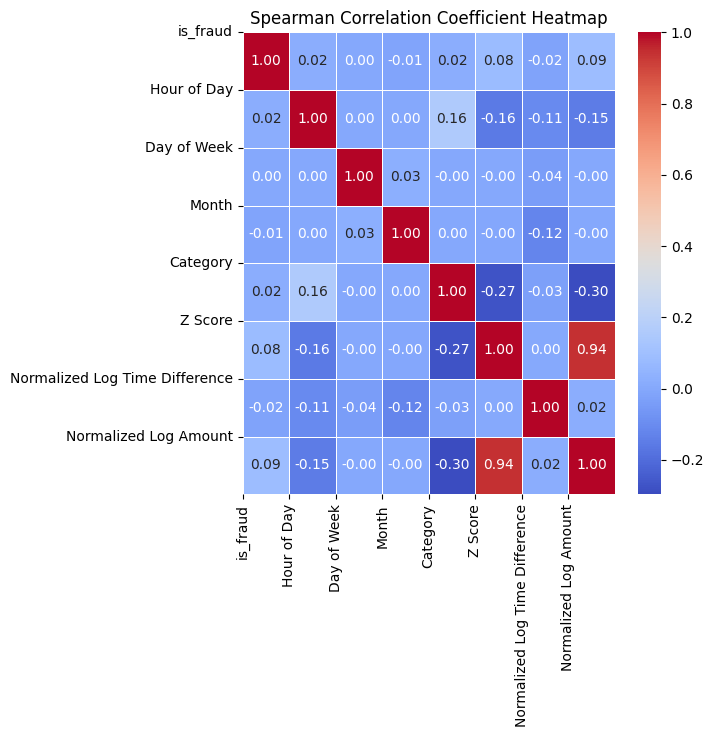

In [355]:
spearman_corr, p_value = spearmanr(df)
plt.figure(figsize=(6, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f")
plt.title('Spearman Correlation Coefficient Heatmap')
plt.xticks(range(len(df.columns)), df.columns, rotation=90)
plt.yticks(range(len(df.columns)), df.columns, rotation=0)
plt.show()

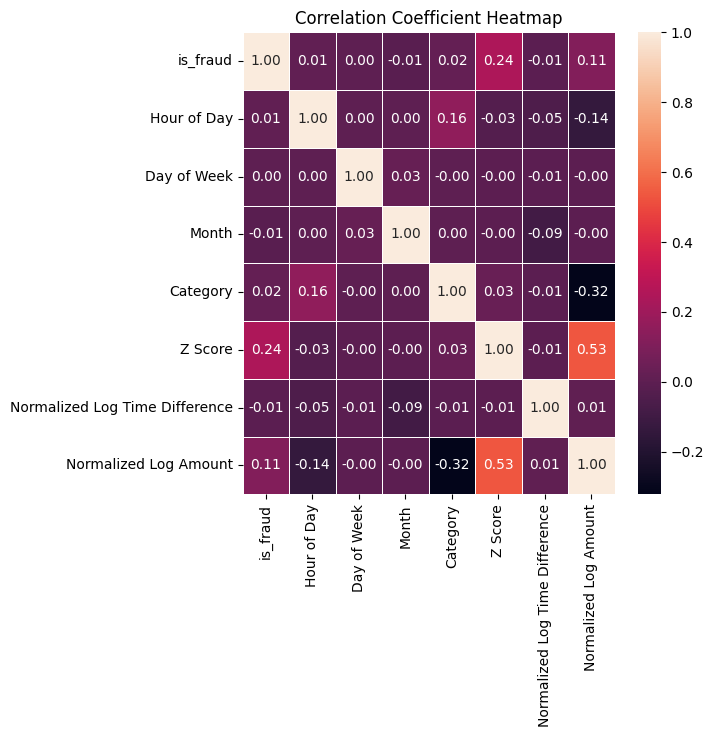

In [356]:
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt=".2f")
plt.title('Correlation Coefficient Heatmap')
plt.show()

In [357]:
#drop unneeded data
df = df.drop("Day of Week", axis = 1)

In [358]:
X = df[['Category', 'Hour of Day', 'Month', 'Z Score', 'Normalized Log Time Difference', 'Normalized Log Amount']]
y = df['is_fraud']

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=10)

In [360]:
%%script false
alpha_list = list(np.arange(0.1,2.5,0.1))
learning_rate_list = list(np.arange(0.1,1,0.1))
param_grid = {
    'alpha': alpha_list,
    'learning_rate': learning_rate_list  
}
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

xgb_model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum())
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=scoring, refit='accuracy')
grid_result = grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

Couldn't find program: 'false'


In [361]:
%%script false
results = pd.DataFrame(grid_result.cv_results_)
pivot_table = results.pivot(index='param_alpha', columns='param_learning_rate', values='mean_test_accuracy')
sns.heatmap(pivot_table, annot=True, fmt=".3f")
plt.title('Grid Search Results')
plt.xlabel('Learning Rate')
plt.ylabel('Alpha')
plt.savefig('accuracy.png')
plt.close()

Couldn't find program: 'false'


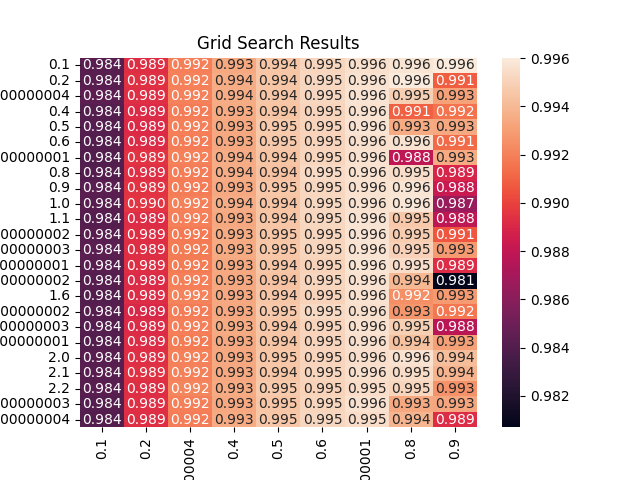

In [362]:
display(Image(filename='accuracy.png'))

In [363]:
results = pd.DataFrame(grid_result.cv_results_)
pivot_table = results.pivot(index='param_alpha', columns='param_learning_rate', values='mean_test_precision')
sns.heatmap(pivot_table, annot=True, fmt=".3f")
plt.title('Precision')
plt.xlabel('Learning Rate')
plt.ylabel('Alpha')
plt.savefig('precision.png')
plt.close()

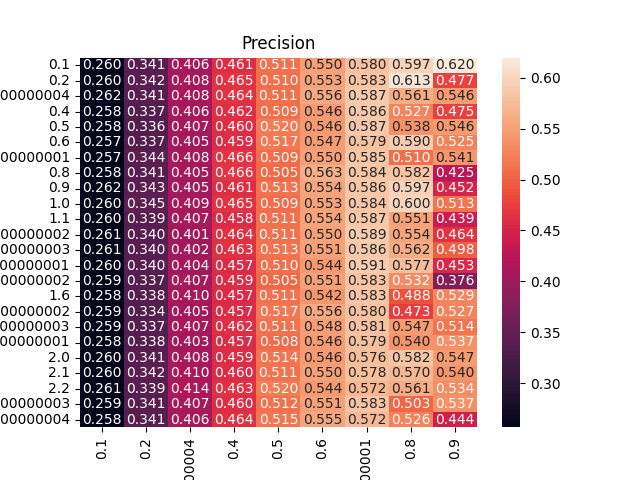

In [364]:
display(Image(filename='precision.png'))

In [365]:
results = pd.DataFrame(grid_result.cv_results_)
pivot_table = results.pivot(index='param_alpha', columns='param_learning_rate', values='mean_test_recall')
sns.heatmap(pivot_table, annot=True, fmt=".3f")
plt.title('Recall')
plt.xlabel('Learning Rate')
plt.ylabel('Alpha')
plt.savefig('recall.png')
plt.close()

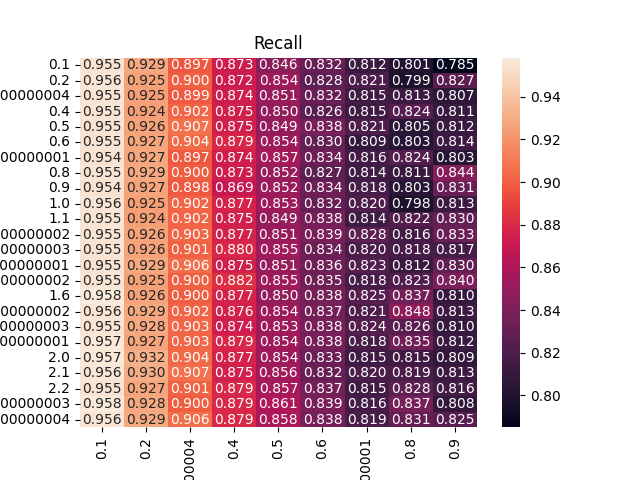

In [366]:
display(Image(filename='recall.png'))

In [367]:
results = pd.DataFrame(grid_result.cv_results_)
pivot_table = results.pivot(index='param_alpha', columns='param_learning_rate', values='mean_test_f1')
sns.heatmap(pivot_table, annot=True, fmt=".3f")
plt.title('F1')
plt.xlabel('Learning Rate')
plt.ylabel('Alpha')
plt.savefig('f1.png')
plt.close()

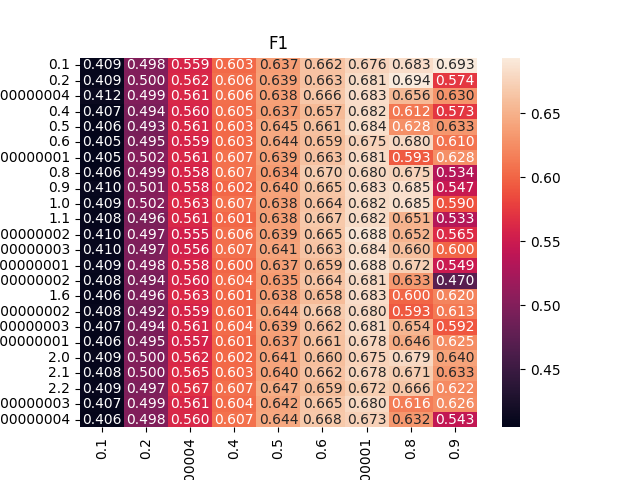

In [368]:
display(Image(filename='f1.png'))

In [369]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(), alpha = 0.1, learning_rate = 0.1)
xgb_model.fit(X_train, y_train)

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [370]:
custom_threshold = 0.3
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba > custom_threshold).astype(int)

In [371]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1_score = (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {F1_score}")
print(f"TP: {TP}")
print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")

Accuracy: 0.9702925342154765
Precision: 0.15702479338842976
Recall: 0.9666666666666667
F1 Score: 0.1350821279725423
TP: 1102
TN: 193365
FP: 5916
FN: 38


In [372]:
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > custom_threshold).astype(int)

In [373]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

accuracy = (TP + TN) / (TP + FP + TN + FN) #(0+2)/(0+1+2+3)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1_score = (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {F1_score}")
print(f"TP: {TP}")
print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")

data = [TP, FP, TN, FN]
with open('metrics.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(data)

Accuracy: 0.9701378598051102
Precision: 0.15718732314657613
Recall: 0.9754170324846356
F1 Score: 0.1353722432070184
TP: 1111
TN: 193325
FP: 5957
FN: 28


In [374]:
filename='trained_model.sav'
pickle.dump(xgb_model,open('trained_model.sav','wb'))
df.to_pickle('data.pkl')

In [375]:
df.head()

,is_fraud,Hour of Day,Month,Category,Z Score,Normalized Log Time Difference,Normalized Log Amount
trans_num,,,,,,,
0b242abb623afc578575680df30655b9,0.0,0,1,8,-0.659837,0.003258,0.156077
1f76529f8574734946361c461b024d99,0.0,0,1,4,0.205372,0.003258,0.455061
a1a22d70485983eac12b5b88dad1cf95,0.0,0,1,0,1.517260,0.003258,0.525063
6b849c168bdad6f867558c3793159a81,0.0,0,1,2,-0.176682,0.003258,0.370540
a41d7549acf90789359a9aa5346dcb46,0.0,0,1,9,-0.204947,0.003258,0.363731


In [376]:
df.describe()

,is_fraud,Hour of Day,Month,Category,Z Score,Normalized Log Time Difference,Normalized Log Amount
count,1.002103e+06,1.002103e+06,1.002103e+06,1.002103e+06,1.002103e+06,1.002103e+06,1.002103e+06
mean,5.701011e-03,1.280453e+01,6.700486e+00,6.228431e+00,2.914202e-18,1.158626e-02,3.364158e-01
std,7.528954e-02,6.816683e+00,3.645710e+00,3.914695e+00,9.998408e-01,2.594362e-02,1.350657e-01
min,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.861071e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,7.000000e+00,3.000000e+00,3.000000e+00,-3.837624e-01,9.396730e-04,2.205644e-01
50%,0.000000e+00,1.400000e+01,7.000000e+00,6.000000e+00,-1.587911e-01,3.257533e-03,3.756387e-01
75%,0.000000e+00,1.900000e+01,1.000000e+01,1.000000e+01,8.713800e-02,1.090021e-02,4.301761e-01
max,1.000000e+00,2.300000e+01,1.200000e+01,1.300000e+01,1.031099e+02,1.000000e+00,1.000000e+00
